In [1]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]


### Creating SQL Database Connection and Converting tables to dfs ###

In [3]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [4]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [5]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [6]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


In [7]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1494r12 1505r15 1514r15 1216r13 1265r13 1314r13 1585r15 1338r13 1343r13 1394r14 1450r15 1082r12
[(236, 847.0, 5), (236, 761.0, 2), (362, 719.0, 5), (408, 675.0, 5), (339, 616, 3), (255, 490, 3), (171, 364, 3), (322, 331.0, 5), (465, 322, 3), (675, 322, 3), (675, 196, 4), (618, 976, 5), (346, 955, 2)]


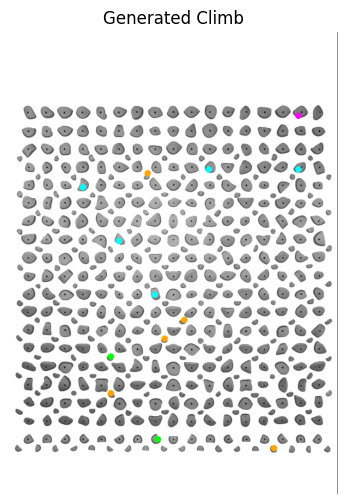

In [8]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1476r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [9]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

### Prepare Data into npz file ###

In [14]:
def get_hold_vector(row, col):
    if 34 - row >  34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    climb_angle_radians = np.deg2rad(climb_angle)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341
    return id



def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        
        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_angle, hold_quality, modified_quality, inter_hold_angle, climb_angle, climb_difficulty)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=10000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = (matrix - global_means) / global_stds
    return standardized_matrix

def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(hold_class_id, val, climb_angle, climb_difficulty):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = class_id_to_id(hold_class_id)
    x, y = id_to_coordinate(hold_id)
    interhold_angle = 0
    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    modified_quality = modified_hold_quality(climb_angle, hold_quality)
    
    feature_tuple = (y, x, val - 2, hold_class_id, hold_angle, hold_quality, modified_quality, interhold_angle, climb_angle, climb_difficulty)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.72929429e+01  1.70281747e+01  1.63512868e+00  2.24845458e+02
 -3.63454780e-03  5.92926999e-01  9.09677322e-01  3.91842491e-01
  3.58443186e+01  4.72786545e+00]


### RNN Model ###

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)
        self.climb_names = list(self.data.keys())
        self.num_climbs = len(self.climb_names)
    
    def __len__(self):
        return self.num_climbs
    
    def __getitem__(self, idx):
        climb_name = self.climb_names[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix

class RNN(nn.Module):
    def __init__(self, input_size=10, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Task-specific layers for classification
        self.fc_val = nn.Linear(hidden_size, 4)  # 4 classes for val
        self.fc_hold_id = nn.Linear(hidden_size, 476)  # 476 classes for hold_id

    def forward(self, x, h0=None, c0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (hn, cn) = self.rnn(x, (h0, c0))
        
        out = out[:, -1, :]  # Get the output of the last time step
        
        val_pred = self.fc_val(out)
        hold_id_pred = self.fc_hold_id(out)
        
        return val_pred, hold_id_pred, hn, cn

def custom_loss(beta, pred_tuple_class_id, pred_tuple_val, expected_tuple_class_id, expected_tuple_val, current_tuple):
    
    climb_angle = current_tuple[8]
    climb_difficulty = current_tuple[9]

    pred_tuple = hold_to_tuple(pred_tuple_class_id, pred_tuple_val, climb_angle, climb_difficulty)

    expected_tuple = hold_to_tuple(expected_tuple_class_id, expected_tuple_val, climb_angle, climb_difficulty)

    pred_tuple_values = pred_tuple[:, [0, 1, 4, 5, 6]] # row, col, hold angle, hold quality, modified hold quality
    expected_tuple_values = expected_tuple[:, [0, 1, 4, 5, 6]]
    
    # Calculate losses for other tuple values (e.g., using L1 or L2 loss)
    loss_other_values = F.mse_loss(pred_tuple_values, expected_tuple_values)
    
    # Weighted sum or combination of losses
    total_loss = beta * loss_other_values
    
    return total_loss

# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Batch size of 1 for sequence data
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Initialize the model and move it to GPU if available
model = RNN().to(device)

# Define loss function and optimizer
criterion_val = nn.CrossEntropyLoss()
criterion_hold_id = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 3  # Example: Train for 10 epochs

beta = 1

# Lists to store loss values
train_losses_val = []
train_losses_hold_id = []
val_losses_val = []
val_losses_hold_id = []
train_losses_custom = []
val_losses_custom = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss_val = 0.0
    running_train_loss_hold_id = 0.0
    running_train_loss_custom = 0.0
    
    # Iterate over data
    for climbs in train_loader:
        climbs = climbs[0].to(device)  # Move data to GPU if available
        num_tuples = len(climbs)
        
        # Accumulate gradients for each batch
        optimizer.zero_grad()
        batch_loss_val = 0.0
        batch_loss_hold_id = 0.0
        batch_loss_custom = 0.0
        
        h0, c0 = None, None  # Initialize hidden states for each new sequence
        
        # Iterate through tuples to predict next tuple's val and hold_id
        for i in range(num_tuples - 1):
            input_sequence = climbs[:i + 1].clone().detach().float().unsqueeze(0)
            next_tuple_val = climbs[i + 1][2].long().unsqueeze(0)
            next_tuple_hold_id = climbs[i + 1][3].long().unsqueeze(0)

            current_tuple = input_sequence[:, -1, :].squeeze(0)
            
            # Forward pass
            val_pred, hold_id_pred, h0, c0 = model(input_sequence, h0, c0)
            
            # Compute standard cross-entropy losses
            loss_val = criterion_val(val_pred, next_tuple_val)
            loss_hold_id = criterion_hold_id(hold_id_pred, next_tuple_hold_id)

            # Compute custom loss
            loss_custom = custom_loss(beta, val_pred, next_tuple_val, hold_id_pred, next_tuple_hold_id, current_tuple)
            
            # Accumulate total batch losses
            batch_loss_val += loss_val
            batch_loss_hold_id += loss_hold_id
            batch_loss_custom += loss_custom
        
        # Combine losses
        batch_loss = batch_loss_val + batch_loss_hold_id + batch_loss_custom
        
        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss_val += batch_loss_val.item()
        running_train_loss_hold_id += batch_loss_hold_id.item()
        running_train_loss_custom += batch_loss_custom.item()
    
    # Compute average training losses
    avg_train_loss_val = running_train_loss_val / len(train_loader)
    avg_train_loss_hold_id = running_train_loss_hold_id / len(train_loader)
    avg_train_loss_custom = running_train_loss_custom / len(train_loader)
    train_losses_val.append(avg_train_loss_val)
    train_losses_hold_id.append(avg_train_loss_hold_id)
    train_losses_custom.append(avg_train_loss_custom)

    # Validation loop
    model.eval()
    running_val_loss_val = 0.0
    running_val_loss_hold_id = 0.0
    running_val_loss_custom = 0.0
    with torch.no_grad():
        for climbs in val_loader:
            climbs = climbs[0].to(device)  # Move data to GPU if available
            num_tuples = len(climbs)
            h0, c0 = None, None  # Initialize hidden states for each new sequence
            for i in range(num_tuples - 1):
                input_sequence = climbs[:i + 1].clone().detach().float().unsqueeze(0)
                next_tuple_val = climbs[i + 1][2].long().unsqueeze(0)
                next_tuple_hold_id = climbs[i + 1][3].long().unsqueeze(0)
                
                current_tuple = input_sequence[:, -1, :].squeeze(0)
                
                # Forward pass
                val_pred, hold_id_pred, h0, c0 = model(input_sequence, h0, c0)

                # Compute standard cross-entropy losses
                loss_val = criterion_val(val_pred, next_tuple_val)
                loss_hold_id = criterion_hold_id(hold_id_pred, next_tuple_hold_id)

                # Compute custom loss
                loss_custom = custom_loss(beta, val_pred, next_tuple_val, hold_id_pred, next_tuple_hold_id, current_tuple)

                running_val_loss_val += loss_val.item()
                running_val_loss_hold_id += loss_hold_id.item()
                running_val_loss_custom += loss_custom.item()

    # Compute average validation losses
    avg_val_loss_val = running_val_loss_val / len(val_loader)
    avg_val_loss_hold_id = running_val_loss_hold_id / len(val_loader)
    avg_val_loss_custom = running_val_loss_custom / len(val_loader)
    val_losses_val.append(avg_val_loss_val)
    val_losses_hold_id.append(avg_val_loss_hold_id)
    val_losses_custom.append(avg_val_loss_custom)

    # Print statistics
    print(f'Epoch {epoch + 1}, Training Loss (Val): {avg_train_loss_val}, Validation Loss (Val): {avg_val_loss_val}')
    print(f'Epoch {epoch + 1}, Training Loss (Hold ID): {avg_train_loss_hold_id}, Validation Loss (Hold ID): {avg_val_loss_hold_id}')
    print(f'Epoch {epoch + 1}, Training Loss (Custom): {avg_train_loss_custom}, Validation Loss (Custom): {avg_val_loss_custom}')

print('Finished Training')

# Plot training and validation losses for each task
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses_val, label='Training Loss (Val)')
plt.plot(range(1, num_epochs + 1), val_losses_val, label='Validation Loss (Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Prediction Training and Validation Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(range(1, num_epochs + 1), train_losses_hold_id, label='Training Loss (Hold ID)')
plt.plot(range(1, num_epochs + 1), val_losses_hold_id, label='Validation Loss (Hold ID)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Hold ID Prediction Training and Validation Loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(range(1, num_epochs + 1), train_losses_custom, label='Training Loss (Custom)')
plt.plot(range(1, num_epochs + 1), val_losses_custom, label='Validation Loss (Custom)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Custom Loss Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

### Generate RNN Climb ###

In [ ]:
import random

def generate_climb(model, starting_hold_id, starting_val, num_holds, climb_angle, climb_difficulty):
    model.eval()
    
    # Initialize the starting tuple and convert to tensor
    starting_class_id = id_to_class_id(starting_hold_id)
    current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val, climb_angle, climb_difficulty)], dtype=torch.float).unsqueeze(0).to(device)

    generated_hold_ids = [starting_hold_id]
    generated_vals = [starting_val]

    # Initialize hidden states
    h0, c0 = None, None
    
    with torch.no_grad():
        for _ in range(num_holds - 1):
            val_prob, hold_id_prob, h0, c0 = model(current_tuple, h0, c0)
            
            val_class = torch.argmax(val_prob, dim=1).item()
            hold_id_top_indices = torch.topk(hold_id_prob, k=5, dim=1)[1].squeeze().tolist()
            # print(f"Hold_id_prob len: {hold_id_prob.size()}")
            hold_id_index = random.choice(hold_id_top_indices)
            # print(f"Hold_id_index: {hold_id_index}")
            hold_id_class = id_to_class_id(hold_id_index)

            generated_hold_ids.append(class_id_to_id(hold_id_index))
            generated_vals.append(val_class)

            # Prepare the next input
            next_tuple = hold_to_tuple(hold_id_class, val_class, climb_angle, climb_difficulty)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
    return generated_hold_ids, generated_vals


# def generate_climb(starting_hold_id, starting_val, num_holds, climb_angle, climb_difficulty):
#     starting_class_id = id_to_class_id(starting_hold_id)
#     current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val, climb_angle, climb_difficulty)], dtype=torch.float).unsqueeze(0).to(device)

#     generated_hold_ids = [starting_hold_id]
#     generated_vals = [starting_val]

#     for _ in range(num_holds - 1):
#         val_prob, hold_id_prob = model(current_tuple)
        
#         val_class = torch.argmax(val_prob, dim=1).item()
#         hold_id_top_indices = torch.topk(hold_id_prob, k=5, dim=1)[1].squeeze().tolist()
#         hold_id_index = random.choice(hold_id_top_indices)
#         hold_id_class = id_to_class_id(hold_id_index)

#         generated_hold_ids.append(class_id_to_id(hold_id_class))
#         generated_vals.append(val_class)

#         # Prepare the next input
#         next_tuple = hold_to_tuple(hold_id_class, val_class, climb_angle, climb_difficulty)
#         next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
        
#         # Concatenate next_tensor along the sequence dimension (dim=1)
#         current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
#     return generated_hold_ids, generated_vals

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
 
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

hold_ids, vals = generate_climb(model, 1467, 3, 12, 45, 5)
climb_to_image(hold_ids, vals)


NameError: name 'model' is not defined

In [ ]:
print(hold_ids, vals)

[1467, 1457, 1145, 1164, 1186, 1153, 1169, 1155, 1153, 1157, 1155, 1157] [3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3]


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
